In [ ]:
# Import needed libraries
import gzip
import json
import pandas as pd
import numpy as np
import pickle
import json
from tqdm import tqdm
from re import escape
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random
import matplotlib.pyplot as plt
# Check and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Run this cell to mount the data drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Loading & Preprocessing

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/IR/dataset_only_essential_features.csv.gz')

In [ ]:
data = data.drop(columns=['title']) #drop columns not needed
data['category'] = data['category'].str.replace('&amp;', '&', regex=False) #fix &amp

# replace all but the 11 categories with most counts with null, which are dropped in the next cell
top_categories = data['category'].value_counts().nlargest(11).index
data['category'] = data['category'].where(data['category'].isin(top_categories), other=pd.NA)
print(data["category"].nunique())

data_dropped = data.dropna() #drop null values

11


In [ ]:
# Filter out all users and items with less than 5 interactions, so after this don't remove any more samples, do that before this
while True:
    user_counts = data_dropped['user_id'].value_counts()
    valid_users = user_counts[user_counts >= 5].index
    data_dropped = data_dropped[data_dropped['user_id'].isin(valid_users)]

    item_counts = data_dropped['item_id'].value_counts()
    valid_items = item_counts[item_counts >= 5].index
    data_dropped = data_dropped[data_dropped['item_id'].isin(valid_items)]

    if len(valid_users) == len(user_counts) and len(valid_items) == len(item_counts):
        break

data_dropped.shape

(4997292, 9)

In [ ]:
def create_subsample(data, user_min_interactions=5, item_min_interactions=4, sample_fraction=0.1, random_state=42):
    """
    Create a representative subsample from the dataset while maintaining minimum user/item interactions.

    Args:
        data (pd.DataFrame): The full dataset.
        user_min_interactions (int): Minimum interactions per user.
        item_min_interactions (int): Minimum reviews per item.
        sample_fraction (float): Fraction of users/items to sample.
        random_state (int): Random seed for reproducibility.

    Returns:
        pd.DataFrame: A smaller, filtered dataset.
    """
    np.random.seed(random_state)

    # Step 1: Sample a fraction of users
    unique_users = data['user_id'].unique()
    for i in range(5): # Check to see that not too many samples are rejected, we don't want to find the same sample every time
      if i == 4:
        print("Too many iterations")
        break
      sampled_users = np.random.choice(unique_users, size=int(len(unique_users) * sample_fraction), replace=True)

      # Create a DataFrame for sampled users
      sampled_users_df = pd.DataFrame({'user_id': sampled_users})
      # Add a unique instance ID for each sampled user
      sampled_users_df['instance_id'] = sampled_users_df.index

      # Merge sampled users with the original data
      data_sampled = sampled_users_df.merge(data, on='user_id', how='inner').copy()

      # Step 2: Filter users and items based on interaction thresholds
      while True:
          # Create a unique identifier for each sampled user-instance pair
          data_sampled['user_instance'] = data_sampled['user_id'].astype(str) + '_' + data_sampled['instance_id'].astype(str)
          # Filter users with at least user_min_interactions based on the unique identifier
          user_counts = data_sampled['user_instance'].value_counts()
          valid_users = user_counts[user_counts >= user_min_interactions].index
          data_sampled = data_sampled[data_sampled['user_instance'].isin(valid_users)].copy()

          # Filter items with at least item_min_interactions
          item_counts = data_sampled['item_id'].value_counts()
          valid_items = item_counts[item_counts >= item_min_interactions].index
          data_sampled = data_sampled[data_sampled['item_id'].isin(valid_items)].copy()

          # Break the loop if no further filtering is needed
          if len(valid_users) == len(user_counts) and len(valid_items) == len(item_counts):
              break

      # Drop the unique identifier column before returning the final dataframe
      data_sampled = data_sampled.drop(columns=['instance_id', 'user_instance'])

      # Enforce our sample to be a specific size so samples are not too different
      if len(data_sampled) < 58000 or len(data_sampled) > 65000:
        print("Rejected: ", len(data_sampled))
      else:
        break

    return data_sampled, len(valid_users)

In [ ]:
def leave_one_out_split_by_item(df):
    """Splits the dataset into train and test sets using a leave-one-out strategy
       by item for each user, ensuring the last interacted item is in the test set.

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        tuple: A tuple containing the train and test DataFrames.
    """

    # Sort by user_id and unixReviewTime to ensure chronological order
    df = df.sort_values(by=['user_id', 'unixReviewTime'])

    # Group by user_id and get the index of the last item interacted with
    last_item_indices = df.groupby('user_id', observed=False).tail(1).index

    # Create the test set using the last item indices
    test_df = df.loc[last_item_indices].copy()

    # Create the train set by excluding the test set
    train_df = df.drop(index=last_item_indices).copy()

    # Ensure no overlap between train and test
    train_df = train_df[~train_df.index.isin(test_df.index)]

    return train_df, test_df

# Model definition

In [ ]:
class L2NormalizationLayer(nn.Module):
    def __init__(self, dim=1, eps=1e-12):
        super(L2NormalizationLayer, self).__init__()
        self.dim = dim
        self.eps = eps

    def forward(self, x):
        return F.normalize(x, p=2, dim=self.dim, eps=self.eps)


class DualAugmentedTwoTowerModel(nn.Module):
    def __init__(self, user_features_list, item_features_list, numeric_columns_user, numeric_columns_item, embedding_dim=32, d=32, num_dim=8):
        super(DualAugmentedTwoTowerModel, self).__init__()

        self.number_numeric_user = len(numeric_columns_user)
        self.number_numeric_item = len(numeric_columns_item)
        # Embedding layers for user and item categorical features
        self.user_feature_embeddings = nn.ModuleList([
            nn.Embedding(int(user_features_list[i+self.number_numeric_user]+1), embedding_dim) for i in range(len(user_features_list)-1-self.number_numeric_user)
        ])
        self.item_feature_embeddings = nn.ModuleList([
            nn.Embedding(int(item_features_list[i+self.number_numeric_item]+1), embedding_dim) for i in range(len(item_features_list)-1-self.number_numeric_item)
        ])

        self.a_u_embedding = nn.Embedding(int(user_features_list[-1]+1), d) #assume augmented user_id is last item
        self.a_v_embedding = nn.Embedding(int(item_features_list[-1]+1), d) #assume augmented item_id is first item

        self.numeric_fc = nn.Sequential(
            nn.Linear(1,num_dim),
            nn.ReLU()
        )

        # FC layers for user tower
        self.user_fc = nn.Sequential(
            nn.Linear(embedding_dim * (len(user_features_list)-self.number_numeric_user) + self.number_numeric_user * num_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            L2NormalizationLayer()
        )

        # FC layers for item tower
        self.item_fc = nn.Sequential(
            nn.Linear(embedding_dim * (len(item_features_list)-self.number_numeric_item) + self.number_numeric_item * num_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            L2NormalizationLayer()
        )

    def forward(self, user_features, item_features):
      user_numeric = [self.numeric_fc(user_features[i].unsqueeze(1).float()) for i in range(self.number_numeric_user)]
      user_numeric_embeds = torch.cat(user_numeric, dim=1)

      item_numeric = [self.numeric_fc(item_features[i].unsqueeze(1).float()) for i in range(self.number_numeric_item)]
      item_numeric_embeds = torch.cat(item_numeric, dim=1)

      user_feature_embeds = [embedding(user_features[i + self.number_numeric_user].long())
                            for i, embedding in enumerate(self.user_feature_embeddings)]
      item_feature_embeds = [embedding(item_features[i + self.number_numeric_item].long())
                            for i, embedding in enumerate(self.item_feature_embeddings)]

      user_augment = self.a_u_embedding(user_features[-1].long())
      item_augment = self.a_v_embedding(item_features[-1].long())

      user_embeds = torch.cat(user_feature_embeds, dim=1)
      item_embeds = torch.cat(item_feature_embeds, dim=1)

      augmented_user_embeds = torch.cat((user_numeric_embeds, user_embeds, user_augment), dim=1)
      augmented_item_embeds = torch.cat((item_numeric_embeds, item_embeds, item_augment), dim=1)

      user_out = self.user_fc(augmented_user_embeds)
      item_out = self.item_fc(augmented_item_embeds)

      dot_product = torch.sum(user_out * item_out, dim=1)

      return dot_product, user_augment, item_augment, user_out, item_out

Loss Functions

In [ ]:
def calculate_covariance(matrix):
    """Compute the covariance matrix for a given set of embeddings."""
    mean = torch.mean(matrix, dim=0, keepdim=True)
    centered_matrix = matrix - mean
    # For a single sample, just return outer product without normalization
    # For multiple samples, divide by N-1
    if matrix.size(0) == 1:
        covariance = torch.mm(centered_matrix.T, centered_matrix)
    else:
        covariance = torch.mm(centered_matrix.T, centered_matrix) / (matrix.size(0) - 1)
    return covariance

def category_alignment_loss(item_out, categories):
    """Compute the Category Alignment Loss (CAL)."""
    # Ensure categories is a LongTensor
    if categories.dtype != torch.long:
        categories = categories.long()

    # Get the unique categories that appear in this batch
    unique_categories = torch.unique(categories)

    # Build a dictionary with embeddings for each category
    category_sets = {cat.item(): item_out[categories == cat] for cat in unique_categories}

    # Determine the major category (largest set of items in the batch)
    major_category = max(category_sets, key=lambda c: category_sets[c].size(0))
    S_major = category_sets[major_category]
    C_major = calculate_covariance(S_major)

    # Compute CAL by comparing C_major with covariances of other categories
    cal_loss = 0.0
    for category, S_i in category_sets.items():
        if category != major_category and S_i.size(0) > 0:
            C_i = calculate_covariance(S_i)
            # Frobenius norm squared of the difference in covariance matrices
            cal_loss += torch.norm(C_major - C_i, p="fro") ** 2

    return cal_loss


# Separated the mimic loss equations in their own functions like in the paper.
def mimic_loss_user(labels, p_u, p_v, a_u):
    # According to the paper: y*a_u + (1-y)*p_v - p_v
    target = labels.unsqueeze(1) * a_u + (1 - labels).unsqueeze(1) * p_v
    return torch.mean((target - p_v)**2)

def mimic_loss_item(labels, p_u, p_v, a_v):
    # According to the paper: y*a_v + (1-y)*p_u - p_u
    target = labels.unsqueeze(1) * a_v + (1 - labels).unsqueeze(1) * p_u
    return torch.mean((target - p_u)**2)

def DAT_loss(predictions, labels, user_augment, item_augment, user_out, item_out, categories, l1=0.5, l2=0.5, l3=1):
    BCE = F.binary_cross_entropy_with_logits(predictions, labels)
    # Apply stop gradient to user_out and item_out before calculating mimic loss
    user_mimic = mimic_loss_user(labels, user_out.detach(), item_out.detach(), user_augment)  # Gradient stopping
    item_mimic = mimic_loss_item(labels, user_out.detach(), item_out.detach(), item_augment)  # Gradient stopping
    CAL = category_alignment_loss(item_out, categories)
    return BCE + l1 * user_mimic + l2 * item_mimic + l3 * CAL

# Training Loop

In [ ]:
# Training Procedure
def negative_sampling(user_id, num_negatives, num_items, items):
    negatives = []
    for i in range(num_negatives):
        neg_item_idx = random.randint(0, len(items) - 1)
        negatives.append(items.iloc[neg_item_idx].values)

    negatives_df = pd.DataFrame(negatives)
    return negatives_df

def train_DAT(model, user_data, item_data, num_items, items_list, num_epochs=10, batch_size=256, num_negatives=5, learning_rate=0.05, patience=3):
    all_losses_per_sample = []
    # Move model to the specified device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

    # Early stopping parameters
    min_delta = 1e-3
    best_loss = float('inf')
    best_model_state = None
    epochs_without_improvement = 0
    smoothing_factor = 0.3

    for epoch in tqdm(range(num_epochs)):
        model.train()

        total_loss_per_sample = 0.0  # Sum of all losses, scaled by batch size
        total_samples = 0          # Total number of samples

        # Shuffle the data at the start of each epoch
        combined_data = pd.concat([user_data, item_data], axis=1)  # Combine the two datasets
        shuffled_data = combined_data.sample(frac=1,).reset_index(drop=True)  # Shuffle together
        user_data = shuffled_data.iloc[:, :len(user_data.columns)].copy()  # Split back to user_data
        item_data = shuffled_data.iloc[:, len(user_data.columns):].copy()  # Split back to item_data

        for batch_start in range(0, len(user_data), batch_size):
            user_batch_data = user_data.iloc[batch_start: batch_start + batch_size]
            item_batch_data = item_data.iloc[batch_start: batch_start + batch_size]

            item_batch_categories = item_batch_data['category']
            item_batch_categories_tensor = torch.tensor(item_batch_categories.values, dtype=torch.float32).to(device)

            batch_size_actual = len(user_batch_data)  # Handle variable batch sizes
            total_samples += batch_size_actual       # Track total samples

            user_ids = torch.tensor(user_batch_data['user_id'].values, dtype=torch.long).to(device)

            negative_samples = []
            for user_id in user_ids:
                neg_items = negative_sampling(user_id, num_negatives, num_items, items_list)
                negative_samples.extend(neg_items.values)

            negative_item_categories = [item[1] for item in negative_samples]
            negative_item_categories = torch.tensor(negative_item_categories, dtype=torch.float32).to(device)

            negative_samples_tensor = torch.tensor(np.array(negative_samples), dtype=torch.float32).to(device)

            user_batch_tensor = torch.tensor(user_batch_data.values, dtype=torch.float32).to(device)
            negative_user_batch_data = user_batch_tensor.repeat_interleave(num_negatives, dim=0)

            item_batch_tensor = torch.tensor(item_batch_data.values, dtype=torch.float32).to(device)

            # Combine positive and negative samples
            all_users = torch.cat([user_batch_tensor, negative_user_batch_data], dim=0)
            all_items = torch.cat([item_batch_tensor, negative_samples_tensor], dim=0)

            all_categories = torch.cat([item_batch_categories_tensor, negative_item_categories], dim=0)

            # Convert to long for embedding inputs
            all_users = all_users.to(torch.long)
            all_items = all_items.to(torch.long)

            # Labels: 1 for positive samples, 0 for negative samples
            labels = torch.cat([torch.ones(len(user_ids)), torch.zeros(len(user_ids) * num_negatives)]).to(device)

            predictions, user_augment, item_augment, user_out, item_out = model(all_users.T, all_items.T)

            # Compute loss
            loss = DAT_loss(predictions, labels, user_augment, item_augment, user_out, item_out, all_categories)

            # Accumulate total per-sample loss (scale batch-averaged loss by batch size)
            total_loss_per_sample += loss.item() * batch_size_actual

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Compute weighted average loss per sample
        avg_loss_per_sample = total_loss_per_sample / total_samples

        all_losses_per_sample.append(avg_loss_per_sample)

        # Step the scheduler
        scheduler.step(avg_loss_per_sample)

        # Print loss every 5 epochs
        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Weigthed Average Loss per Sample: {avg_loss_per_sample}')
            lr = scheduler.get_last_lr()[0]  # Get the current learning rate
            print(f"Current learning rate: {lr}")

        # Smooth loss computation Exponential Moving Average (EMA)
        if epoch == 0:
            smoothed_loss = avg_loss_per_sample
        else:
            smoothed_loss = smoothing_factor * avg_loss_per_sample + (1 - smoothing_factor) * smoothed_loss

        # Check for improvement
        if smoothed_loss < best_loss - min_delta:
            best_loss = smoothed_loss
            best_model_state = model.state_dict()  # Save the best model
            epochs_without_improvement = 0
        else:
          epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered. Best Average Loss per Batch: {best_loss:.4f}")
            model.load_state_dict(best_model_state)
            break

    return all_losses_per_sample

# Evaluation Metrics

In [ ]:
# Extract all items every user has interected with in the training set
def get_interacted_items(df, user_id_col='user_id', item_id_col='item_id'):
    interacted_items = (
        df.groupby(user_id_col)[item_id_col]
        .apply(set)  # Collect all item_ids for each user into a set
        .to_dict()
    )
    return interacted_items

In [ ]:
def evaluation_metrics(model, users, interacted_items, items, test_items, K_list):
    model.eval()
    device = next(model.parameters()).device
    with torch.no_grad():
      # Precompute all embeddings for users and items
      user_tensor = torch.tensor(users.values, dtype=torch.float32).T.to(device)
      item_tensor = torch.tensor(items.values, dtype=torch.float32).T.to(device)

      _, _, _, user_outputs, _ = model(user_tensor, item_tensor[:, :1])  # User embeddings
      _, _, _, _, item_outputs = model(user_tensor[:, :1], item_tensor)  # Item embeddings

      # Move to device for computation
      interacted_items = [torch.tensor(interacted, device=device) for interacted in interacted_items]
      test_item_indices = torch.tensor(test_items['item_id'].values, device=device)

      ranks = torch.zeros(len(users), device=device)
      hits = torch.zeros(len(K_list), device=device)

      # Compute all scores
      scores = torch.matmul(user_outputs, item_outputs.T)  # Shape: (num_users, num_items)

      for i, interacted in enumerate(interacted_items):
          # Mask interacted items
          scores[i, interacted] = float('-inf')

      # Get test item scores
      test_item_scores = scores[torch.arange(len(users), device=device), test_item_indices]

      # Compute ranks
      ranks = (scores > test_item_scores.unsqueeze(1)).sum(dim=1) + 1  # Rank is 1-based

      default_rank = len(items) + 1
      missing_items = torch.tensor([item_id not in items['item_id'].values for item_id in test_items['item_id'].values], device=device)

      # Count how many are True (missing items)
      num_missing = torch.sum(missing_items).item()

      # Count how many are False (present items)
      num_present = len(missing_items) - num_missing

      print(f"Number of missing items (True): {num_missing}")
      print(f"Number of present items (False): {num_present}")

      ranks[missing_items] = default_rank

      # Compute hit rates
      for k_idx, K in enumerate(K_list):
          hits[k_idx] = ((ranks <= K) & ~missing_items).sum().item()  # Exclude missing items from hits

      # Compute hit rates
      hitrates = [hit.item() / len(users) for hit in hits]

      # Compute MRR
      mrr = (1.0 / ranks).mean().item() * 10  # Include default rank in MRR

      return hitrates, mrr

In [ ]:
def training_eval_pipeline(train_user, train_item, all_items, test_user, test_item, interacted_items, data):
  # Metrics needed to initialize model
  max_user_features = train_user.max().tolist()
  max_item_features = all_items.max().tolist()
  numeric_columns_user = ["overall", "total_user_reviews", "average_rating"]
  numeric_columns_item = ["price", "books_rank"]
  model = DualAugmentedTwoTowerModel(max_user_features, max_item_features, numeric_columns_user, numeric_columns_item)  # Initialize the model
  model = model.to(device)  # Move model to the device (GPU/CPU)

  # Train the model
  all_sample_losses = train_DAT(model, train_user, train_item, data['item_id'].nunique(), all_items, num_epochs=50, batch_size=256, num_negatives=5, learning_rate=0.05)

  K_list = [50, 100]
  hitrates, mrr = evaluation_metrics(model, test_user, interacted_items, all_items, test_item, K_list)
  print("hitrate@50: ", hitrates[0])
  print("hitrate@100: ", hitrates[1])
  print("MRR: ", mrr)
  print("\n")
  # Flush GPU RAM
  del model
  torch.cuda.empty_cache()
  return hitrates, mrr, all_sample_losses

In [ ]:
def bootstrapping_pipeline(data, random_states, sample_fraction=0.035):
  # Lists to keep track of metrics for all bootrapping samples
  all_hitrates = []
  all_mrr = []
  all_sample_losses = []
  all_interactions = []
  all_users = []

  for index, random_state in enumerate(random_states):
    print(f"Sample: {index + 1}")
    sampled_data,  u = create_subsample(data, sample_fraction=sample_fraction, random_state=int(random_state))
    columns_one_hot = ['user_id', 'item_id', 'category']
    numeric_columns_user = ["overall", "total_user_reviews", "average_rating"]
    numeric_columns_item = ["price", "books_rank"]

    print(f"interactions: {len(sampled_data)}")
    print(f"users: {u}\n")
    all_interactions.append(len(sampled_data))
    all_users.append(u)

    for column in columns_one_hot:
        if column in sampled_data.columns:  # Ensure the column exists in the DataFrame
            unique_values = sampled_data[column].unique()  # Get unique values
            mapping = {old_value: new_value for new_value, old_value in enumerate(unique_values)}  # Create mapping
            sampled_data[column] = sampled_data[column].map(mapping)  # Apply mapping

    all_sample_items = sampled_data.drop(columns=['unixReviewTime', 'user_id', 'total_user_reviews', 'overall', 'average_rating'])
    all_sample_items = all_sample_items.drop_duplicates()
    all_sample_items['a_v'] = all_sample_items['item_id']

    train, test = leave_one_out_split_by_item(sampled_data)
    print(f"Train shape: {train.shape}")
    print(f"Test shape: {test.shape}\n")
    train_user = train.drop(columns=['item_id', 'unixReviewTime', 'price', 'books_rank', 'category'])
    test_user = test.drop(columns=['item_id', 'unixReviewTime', 'price', 'books_rank', 'category'])
    train_item = train.drop(columns=['user_id', 'overall', 'unixReviewTime', 'total_user_reviews', 'average_rating'])
    test_item = test.drop(columns=['user_id', 'overall', 'unixReviewTime', 'total_user_reviews', 'average_rating'])

    train_user['a_u'] = train_user['user_id']
    test_user['a_u'] = test_user['user_id']
    train_item['a_v'] = train_item['item_id']
    test_item['a_v'] = test_item['item_id']

    interacted_items = get_interacted_items(train)

    hitrates, mrr, sample_losses = training_eval_pipeline(train_user, train_item, all_sample_items, test_user, test_item, interacted_items, data)
    all_hitrates.append(hitrates)
    all_mrr.append(mrr)
    all_sample_losses.append(sample_losses)

  print(f"Mean Interactions: {np.mean(all_interactions)} +- {np.std(all_interactions)}")
  print(f"Mean Users: {np.mean(all_users)} +- {np.std(all_users)}\n")

  return all_hitrates, all_mrr, all_sample_losses

In [ ]:
num_samples = 35
random_states = np.linspace(15, 3242, num_samples)
all_hitrates, all_mrr, all_sample_losses = bootstrapping_pipeline(data_dropped, random_states)

Sample: 1
interactions: 58123
users: 4839

Train shape: (53375, 9)
Test shape: (4748, 9)



 10%|█         | 5/50 [02:35<23:13, 30.97s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.48081619078939913
Current learning rate: 0.05


 20%|██        | 10/50 [05:09<20:35, 30.89s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.4783462713741865
Current learning rate: 0.025


 30%|███       | 15/50 [07:44<18:00, 30.87s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.47838398981931896
Current learning rate: 0.0125


 30%|███       | 15/50 [08:14<19:14, 33.00s/it]

Early stopping triggered. Best Average Loss per Batch: 0.4795


Number of missing items (True): 0
Number of present items (False): 4748
hitrate@50:  0.04865206402695872
hitrate@100:  0.08003369839932603
MRR:  0.08186447434127331


Sample: 2
interactions: 58824
users: 4970

Train shape: (53967, 9)
Test shape: (4857, 9)



 10%|█         | 5/50 [02:36<23:28, 31.29s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.4806724704652519
Current learning rate: 0.05


 20%|██        | 10/50 [05:13<20:55, 31.39s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.47844886260741987
Current learning rate: 0.025


 30%|███       | 15/50 [07:49<18:15, 31.31s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.4780081050766226
Current learning rate: 0.0125


 36%|███▌      | 18/50 [09:55<17:38, 33.08s/it]

Early stopping triggered. Best Average Loss per Batch: 0.4786


Number of missing items (True): 0
Number of present items (False): 4857
hitrate@50:  0.041589458513485694
hitrate@100:  0.07144327774346304
MRR:  0.08252267725765705


Sample: 3
interactions: 58152
users: 4939

Train shape: (53319, 9)
Test shape: (4833, 9)



 10%|█         | 5/50 [02:34<23:12, 30.95s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.47973387263363554
Current learning rate: 0.05


 20%|██        | 10/50 [05:08<20:34, 30.86s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.47981600584597306
Current learning rate: 0.025


 30%|███       | 15/50 [07:43<18:02, 30.92s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.4781456129486856
Current learning rate: 0.0125


 36%|███▌      | 18/50 [09:47<17:24, 32.63s/it]

Early stopping triggered. Best Average Loss per Batch: 0.4786


Number of missing items (True): 0
Number of present items (False): 4833
hitrate@50:  0.049865507966066626
hitrate@100:  0.07945375543140906
MRR:  0.09955297224223614


Sample: 4
Rejected:  56382
Rejected:  55919
interactions: 58058
users: 4810

Train shape: (53362, 9)
Test shape: (4696, 9)



 10%|█         | 5/50 [02:35<23:22, 31.16s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.4804687047776761
Current learning rate: 0.05


 20%|██        | 10/50 [05:10<20:39, 31.00s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.4799793092474257
Current learning rate: 0.05


 30%|███       | 15/50 [07:44<18:00, 30.88s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.4782491212109031
Current learning rate: 0.025


 38%|███▊      | 19/50 [10:19<16:50, 32.58s/it]

Epoch 20/50, Weigthed Average Loss per Sample: 0.4785022725196557
Current learning rate: 0.0125
Early stopping triggered. Best Average Loss per Batch: 0.4788


Number of missing items (True): 0
Number of present items (False): 4696
hitrate@50:  0.04237649063032368
hitrate@100:  0.07005962521294719
MRR:  0.06590359378606081


Sample: 5
interactions: 59494
users: 4915

Train shape: (54691, 9)
Test shape: (4803, 9)



 10%|█         | 5/50 [02:38<23:47, 31.73s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.4797480651929543
Current learning rate: 0.05


 20%|██        | 10/50 [05:17<21:09, 31.74s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.47842120360995505
Current learning rate: 0.025


 30%|███       | 15/50 [07:55<18:25, 31.58s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.4781065414559396
Current learning rate: 0.0125


 30%|███       | 15/50 [08:26<19:41, 33.77s/it]

Early stopping triggered. Best Average Loss per Batch: 0.4793


Number of missing items (True): 0
Number of present items (False): 4803
hitrate@50:  0.050385175931709346
hitrate@100:  0.0795336248178222
MRR:  0.0807512179017067


Sample: 6
interactions: 59591
users: 5010

Train shape: (54693, 9)
Test shape: (4898, 9)



 10%|█         | 5/50 [02:38<23:45, 31.68s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.48081768434327515
Current learning rate: 0.05


 20%|██        | 10/50 [05:16<21:01, 31.55s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.48036606671041054
Current learning rate: 0.05


 30%|███       | 15/50 [07:54<18:27, 31.64s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.47897090776762247
Current learning rate: 0.025


 38%|███▊      | 19/50 [10:32<17:12, 33.30s/it]

Epoch 20/50, Weigthed Average Loss per Sample: 0.47837355229482875
Current learning rate: 0.0125
Early stopping triggered. Best Average Loss per Batch: 0.4794


Number of missing items (True): 0
Number of present items (False): 4898
hitrate@50:  0.04409963250306247
hitrate@100:  0.07145773785218457
MRR:  0.08115284144878387


Sample: 7
interactions: 59053
users: 4921

Train shape: (54246, 9)
Test shape: (4807, 9)



 10%|█         | 5/50 [02:37<23:32, 31.38s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.480867736164335
Current learning rate: 0.05


 20%|██        | 10/50 [05:13<20:52, 31.31s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.4793774687456697
Current learning rate: 0.025


 30%|███       | 15/50 [07:50<18:21, 31.46s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.478683125947256
Current learning rate: 0.025


 30%|███       | 15/50 [08:22<19:31, 33.47s/it]

Early stopping triggered. Best Average Loss per Batch: 0.4801


Number of missing items (True): 0
Number of present items (False): 4807
hitrate@50:  0.04951112960266278
hitrate@100:  0.07842729353026835
MRR:  0.08121720515191555


Sample: 8
interactions: 61415
users: 4897

Train shape: (56637, 9)
Test shape: (4778, 9)



 10%|█         | 5/50 [02:43<24:27, 32.62s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.4798476857141744
Current learning rate: 0.05


 20%|██        | 10/50 [05:26<21:45, 32.63s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.4782240023817057
Current learning rate: 0.025


 30%|███       | 15/50 [08:10<19:03, 32.68s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.47805809811864497
Current learning rate: 0.0125


 30%|███       | 15/50 [08:42<20:19, 34.85s/it]

Early stopping triggered. Best Average Loss per Batch: 0.4794


Number of missing items (True): 0
Number of present items (False): 4778
hitrate@50:  0.05002092925910423
hitrate@100:  0.07848472164085392
MRR:  0.09253588505089283


Sample: 9
Rejected:  56600
interactions: 60474
users: 4963

Train shape: (55621, 9)
Test shape: (4853, 9)



 10%|█         | 5/50 [02:41<24:13, 32.29s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.4808104627453388
Current learning rate: 0.05


 20%|██        | 10/50 [05:24<21:37, 32.45s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.48004582458502076
Current learning rate: 0.05


 30%|███       | 15/50 [08:05<18:50, 32.29s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.4784317686723828
Current learning rate: 0.025


 40%|████      | 20/50 [10:47<16:11, 32.39s/it]

Epoch 20/50, Weigthed Average Loss per Sample: 0.4777958039778044
Current learning rate: 0.0125


 40%|████      | 20/50 [11:19<16:59, 33.97s/it]

Early stopping triggered. Best Average Loss per Batch: 0.4788


Number of missing items (True): 0
Number of present items (False): 4853
hitrate@50:  0.049660004121162164
hitrate@100:  0.07521120956109623
MRR:  0.08601801469922066


Sample: 10
interactions: 59219
users: 4817

Train shape: (54510, 9)
Test shape: (4709, 9)



 10%|█         | 5/50 [02:38<23:45, 31.67s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.48068613342201355
Current learning rate: 0.05


 20%|██        | 10/50 [05:16<21:01, 31.55s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.47989743615898206
Current learning rate: 0.05


 30%|███       | 15/50 [07:53<18:19, 31.40s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.47795867449842316
Current learning rate: 0.025


 38%|███▊      | 19/50 [10:31<17:10, 33.23s/it]

Epoch 20/50, Weigthed Average Loss per Sample: 0.4777454950299488
Current learning rate: 0.0125
Early stopping triggered. Best Average Loss per Batch: 0.4787


Number of missing items (True): 0
Number of present items (False): 4709
hitrate@50:  0.04799320450201741
hitrate@100:  0.07899766404756849
MRR:  0.0905666034668684


Sample: 11
interactions: 60042
users: 4952

Train shape: (55200, 9)
Test shape: (4842, 9)



 10%|█         | 5/50 [02:39<23:56, 31.93s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.48033823922060537
Current learning rate: 0.05


 20%|██        | 10/50 [05:19<21:18, 31.96s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.48000472607819933
Current learning rate: 0.05


 30%|███       | 15/50 [07:58<18:34, 31.85s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.4780562029368636
Current learning rate: 0.025


 32%|███▏      | 16/50 [09:02<19:13, 33.93s/it]

Early stopping triggered. Best Average Loss per Batch: 0.4794


Number of missing items (True): 0
Number of present items (False): 4842
hitrate@50:  0.05163155720776538
hitrate@100:  0.080545229244114
MRR:  0.1080191507935524


Sample: 12
interactions: 60335
users: 5069

Train shape: (55376, 9)
Test shape: (4959, 9)



 10%|█         | 5/50 [02:40<24:03, 32.07s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.4796772086871769
Current learning rate: 0.05


 20%|██        | 10/50 [05:21<21:24, 32.12s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.4784724619201896
Current learning rate: 0.025


 30%|███       | 15/50 [08:01<18:42, 32.06s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.47818293781750326
Current learning rate: 0.0125


 30%|███       | 15/50 [08:34<19:59, 34.27s/it]

Early stopping triggered. Best Average Loss per Batch: 0.4794


Number of missing items (True): 0
Number of present items (False): 4959
hitrate@50:  0.045372050816696916
hitrate@100:  0.07380520266182698
MRR:  0.08423368446528912


Sample: 13
Rejected:  54689
Rejected:  65349
Rejected:  57817
interactions: 60415
users: 4904

Train shape: (55645, 9)
Test shape: (4770, 9)



 10%|█         | 5/50 [02:39<24:01, 32.04s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.47962167874930606
Current learning rate: 0.05


 20%|██        | 10/50 [05:20<21:22, 32.05s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.47819230592800327
Current learning rate: 0.025


 30%|███       | 15/50 [08:01<18:40, 32.03s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.4778286751662638
Current learning rate: 0.0125


 34%|███▍      | 17/50 [09:38<18:42, 34.02s/it]

Early stopping triggered. Best Average Loss per Batch: 0.4786


Number of missing items (True): 0
Number of present items (False): 4770
hitrate@50:  0.0509433962264151
hitrate@100:  0.07945492662473795
MRR:  0.07753422018140554


Sample: 14
interactions: 62010
users: 4882

Train shape: (57231, 9)
Test shape: (4779, 9)



 10%|█         | 5/50 [02:46<25:04, 33.44s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.4805660294049423
Current learning rate: 0.05


 20%|██        | 10/50 [05:34<22:16, 33.42s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.48028171920071916
Current learning rate: 0.05


 30%|███       | 15/50 [08:19<19:21, 33.19s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.47853037947831956
Current learning rate: 0.025


 32%|███▏      | 16/50 [09:26<20:03, 35.40s/it]

Early stopping triggered. Best Average Loss per Batch: 0.4798


Number of missing items (True): 0
Number of present items (False): 4779
hitrate@50:  0.03871102741159238
hitrate@100:  0.06277463904582549
MRR:  0.07949346676468849


Sample: 15
interactions: 58792
users: 4831

Train shape: (54063, 9)
Test shape: (4729, 9)



 10%|█         | 5/50 [02:37<23:35, 31.46s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.4800516796295517
Current learning rate: 0.05


 20%|██        | 10/50 [05:14<20:58, 31.47s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.47994953989288025
Current learning rate: 0.025


 30%|███       | 15/50 [07:51<18:19, 31.40s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.478233076192813
Current learning rate: 0.0125


 36%|███▌      | 18/50 [09:57<17:41, 33.18s/it]

Early stopping triggered. Best Average Loss per Batch: 0.4786


Number of missing items (True): 0
Number of present items (False): 4729
hitrate@50:  0.05032776485514908
hitrate@100:  0.08098963840135336
MRR:  0.08733722381293774


Sample: 16
interactions: 59530
users: 4914

Train shape: (54733, 9)
Test shape: (4797, 9)



 10%|█         | 5/50 [02:39<24:00, 32.02s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.48025406130815157
Current learning rate: 0.05


 20%|██        | 10/50 [05:18<21:10, 31.76s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.48002735230833965
Current learning rate: 0.05


 30%|███       | 15/50 [07:58<18:39, 31.99s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.4783040934561847
Current learning rate: 0.025


 32%|███▏      | 16/50 [09:02<19:12, 33.91s/it]

Early stopping triggered. Best Average Loss per Batch: 0.4794


Number of missing items (True): 0
Number of present items (False): 4797
hitrate@50:  0.0498228059203669
hitrate@100:  0.07483844069209923
MRR:  0.09007658809423447


Sample: 17
interactions: 62137
users: 5049

Train shape: (57198, 9)
Test shape: (4939, 9)



 10%|█         | 5/50 [02:46<25:00, 33.34s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.47998593335318573
Current learning rate: 0.05


 20%|██        | 10/50 [05:34<22:21, 33.53s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.4799519840645754
Current learning rate: 0.025


 30%|███       | 15/50 [08:22<19:33, 33.54s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.4782096913421174
Current learning rate: 0.0125


 36%|███▌      | 18/50 [10:35<18:49, 35.31s/it]

Early stopping triggered. Best Average Loss per Batch: 0.4785


Number of missing items (True): 0
Number of present items (False): 4939
hitrate@50:  0.051022474185057703
hitrate@100:  0.0757238307349666
MRR:  0.08756875060498714


Sample: 18
interactions: 61779
users: 4983

Train shape: (56888, 9)
Test shape: (4891, 9)



 10%|█         | 5/50 [02:45<24:42, 32.94s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.4806718508447211
Current learning rate: 0.05


 20%|██        | 10/50 [05:30<22:04, 33.10s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.4800103879388987
Current learning rate: 0.05


 30%|███       | 15/50 [08:16<19:18, 33.10s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.4780503486953293
Current learning rate: 0.025


 36%|███▌      | 18/50 [10:28<18:36, 34.89s/it]

Early stopping triggered. Best Average Loss per Batch: 0.4792


Number of missing items (True): 0
Number of present items (False): 4891
hitrate@50:  0.04947863422612962
hitrate@100:  0.08035166632590472
MRR:  0.08362251333892345


Sample: 19
Rejected:  69621
Rejected:  56130
interactions: 60704
users: 4977

Train shape: (55847, 9)
Test shape: (4857, 9)



 10%|█         | 5/50 [02:41<24:10, 32.23s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.48048769071451913
Current learning rate: 0.05


 20%|██        | 10/50 [05:22<21:29, 32.25s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.4782694751503137
Current learning rate: 0.025


 30%|███       | 15/50 [08:04<18:49, 32.26s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.47781842567639904
Current learning rate: 0.0125


 36%|███▌      | 18/50 [10:12<18:08, 34.02s/it]

Early stopping triggered. Best Average Loss per Batch: 0.4783


Number of missing items (True): 0
Number of present items (False): 4857
hitrate@50:  0.051266213712168
hitrate@100:  0.07556104591311509
MRR:  0.10063125751912594


Sample: 20
Rejected:  55377
Rejected:  54276
Rejected:  56594
interactions: 59805
users: 4880

Train shape: (55040, 9)
Test shape: (4765, 9)



 10%|█         | 5/50 [02:39<23:52, 31.84s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.4808446527913559
Current learning rate: 0.05


 20%|██        | 10/50 [05:18<21:10, 31.77s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.4787225791188173
Current learning rate: 0.025


 30%|███       | 15/50 [07:57<18:36, 31.89s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.47805656818456427
Current learning rate: 0.0125


 36%|███▌      | 18/50 [10:05<17:56, 33.64s/it]

Early stopping triggered. Best Average Loss per Batch: 0.4788


Number of missing items (True): 0
Number of present items (False): 4765
hitrate@50:  0.05225603357817419
hitrate@100:  0.0770199370409234
MRR:  0.09166876785457134


Sample: 21
Rejected:  56205
interactions: 63318
users: 5020

Train shape: (58417, 9)
Test shape: (4901, 9)



 10%|█         | 5/50 [02:49<25:17, 33.72s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.4801039308866145
Current learning rate: 0.05


 20%|██        | 10/50 [05:38<22:36, 33.91s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.48004448150348533
Current learning rate: 0.025


 30%|███       | 15/50 [08:27<19:43, 33.81s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.4781634133433925
Current learning rate: 0.0125


 36%|███▌      | 18/50 [10:42<19:03, 35.72s/it]

Early stopping triggered. Best Average Loss per Batch: 0.4786


Number of missing items (True): 0
Number of present items (False): 4901
hitrate@50:  0.05100999795960008
hitrate@100:  0.07345439706182412
MRR:  0.08380942046642303


Sample: 22
interactions: 61951
users: 4970

Train shape: (57105, 9)
Test shape: (4846, 9)



 10%|█         | 5/50 [02:45<24:47, 33.06s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.4798038574184013
Current learning rate: 0.05


 20%|██        | 10/50 [05:30<21:57, 32.95s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.47822926536863924
Current learning rate: 0.025


 30%|███       | 15/50 [08:15<19:17, 33.07s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.4778870779227359
Current learning rate: 0.0125


 34%|███▍      | 17/50 [09:54<19:14, 34.98s/it]

Early stopping triggered. Best Average Loss per Batch: 0.4787


Number of missing items (True): 0
Number of present items (False): 4846
hitrate@50:  0.0505571605447792
hitrate@100:  0.07944696657036732
MRR:  0.0873176846653223


Sample: 23
Rejected:  57822
interactions: 58668
users: 4874

Train shape: (53916, 9)
Test shape: (4752, 9)



 10%|█         | 5/50 [02:35<23:17, 31.05s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.48081539069936735
Current learning rate: 0.05


 20%|██        | 10/50 [05:12<20:54, 31.35s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.47993582413037195
Current learning rate: 0.025


 28%|██▊       | 14/50 [07:48<20:03, 33.43s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.4799284721015159
Current learning rate: 0.00625
Early stopping triggered. Best Average Loss per Batch: 0.4813


Number of missing items (True): 0
Number of present items (False): 4752
hitrate@50:  0.01494107744107744
hitrate@100:  0.029671717171717172
MRR:  0.016734469681978226


Sample: 24
interactions: 58133
users: 4905

Train shape: (53337, 9)
Test shape: (4796, 9)



 10%|█         | 5/50 [02:35<23:16, 31.04s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.4800568361101491
Current learning rate: 0.05


 20%|██        | 10/50 [05:08<20:32, 30.82s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.4802453449745692
Current learning rate: 0.05


 30%|███       | 15/50 [07:43<18:01, 30.91s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.4783944164460387
Current learning rate: 0.025


 32%|███▏      | 16/50 [08:45<18:35, 32.82s/it]

Early stopping triggered. Best Average Loss per Batch: 0.4796


Number of missing items (True): 0
Number of present items (False): 4796
hitrate@50:  0.04274395329441201
hitrate@100:  0.06755629691409508
MRR:  0.07263509090989828


Sample: 25
interactions: 58845
users: 4847

Train shape: (54116, 9)
Test shape: (4729, 9)



 10%|█         | 5/50 [02:37<23:35, 31.45s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.47960931656365735
Current learning rate: 0.05


 20%|██        | 10/50 [05:13<20:54, 31.36s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.4782512568213281
Current learning rate: 0.025


 30%|███       | 15/50 [07:50<18:20, 31.44s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.47821490299949293
Current learning rate: 0.0125


 34%|███▍      | 17/50 [09:24<18:16, 33.23s/it]

Early stopping triggered. Best Average Loss per Batch: 0.4788


Number of missing items (True): 0
Number of present items (False): 4729
hitrate@50:  0.04779023049270459
hitrate@100:  0.07676041446394587
MRR:  0.09607154875993729


Sample: 26
interactions: 64930
users: 5136

Train shape: (59902, 9)
Test shape: (5028, 9)



 10%|█         | 5/50 [02:54<26:07, 34.84s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.4802559763118503
Current learning rate: 0.05


 20%|██        | 10/50 [05:47<23:06, 34.66s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.4784760278300775
Current learning rate: 0.025


 30%|███       | 15/50 [08:40<20:12, 34.65s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.47801258331773866
Current learning rate: 0.0125


 36%|███▌      | 18/50 [10:58<19:31, 36.61s/it]

Early stopping triggered. Best Average Loss per Batch: 0.4785


Number of missing items (True): 0
Number of present items (False): 5028
hitrate@50:  0.04753381066030231
hitrate@100:  0.07199681782020684
MRR:  0.09467327035963535


Sample: 27
interactions: 59899
users: 4926

Train shape: (55088, 9)
Test shape: (4811, 9)



 10%|█         | 5/50 [02:39<23:51, 31.82s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.480097593400425
Current learning rate: 0.05


 20%|██        | 10/50 [05:18<21:13, 31.85s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.4798652714779998
Current learning rate: 0.05


 30%|███       | 15/50 [07:57<18:31, 31.75s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.47812308284075083
Current learning rate: 0.025


 32%|███▏      | 16/50 [09:00<19:08, 33.79s/it]

Early stopping triggered. Best Average Loss per Batch: 0.4794


Number of missing items (True): 0
Number of present items (False): 4811
hitrate@50:  0.05092496362502598
hitrate@100:  0.07607565994595718
MRR:  0.07501114159822464


Sample: 28
interactions: 61821
users: 5077

Train shape: (56868, 9)
Test shape: (4953, 9)



 10%|█         | 5/50 [02:45<24:47, 33.05s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.4809059120812664
Current learning rate: 0.05


 20%|██        | 10/50 [05:29<21:56, 32.92s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.4786040804163434
Current learning rate: 0.025


 30%|███       | 15/50 [08:14<19:12, 32.94s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.4783131398693992
Current learning rate: 0.0125


 34%|███▍      | 17/50 [09:53<19:11, 34.91s/it]

Early stopping triggered. Best Average Loss per Batch: 0.4790


Number of missing items (True): 0
Number of present items (False): 4953
hitrate@50:  0.044215626892792244
hitrate@100:  0.07349081364829396
MRR:  0.07693676743656397


Sample: 29
Rejected:  56300
interactions: 58973
users: 4879

Train shape: (54212, 9)
Test shape: (4761, 9)



 10%|█         | 5/50 [02:36<23:24, 31.21s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.48090302559367704
Current learning rate: 0.05


 20%|██        | 10/50 [05:12<20:55, 31.39s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.4786164749748793
Current learning rate: 0.025


 30%|███       | 15/50 [07:50<18:23, 31.52s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.4784613842674967
Current learning rate: 0.0125


 30%|███       | 15/50 [08:21<19:30, 33.44s/it]

Early stopping triggered. Best Average Loss per Batch: 0.4797


Number of missing items (True): 0
Number of present items (False): 4761
hitrate@50:  0.04452846040747742
hitrate@100:  0.07666456626759084
MRR:  0.09330655448138714


Sample: 30
interactions: 60776
users: 4932

Train shape: (55962, 9)
Test shape: (4814, 9)



 10%|█         | 5/50 [02:41<24:12, 32.28s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.48091293108424515
Current learning rate: 0.05


 20%|██        | 10/50 [05:23<21:32, 32.31s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.47871755644381375
Current learning rate: 0.025


 30%|███       | 15/50 [08:06<19:00, 32.60s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.47830525592982925
Current learning rate: 0.0125


 36%|███▌      | 18/50 [10:15<18:13, 34.18s/it]

Early stopping triggered. Best Average Loss per Batch: 0.4789


Number of missing items (True): 0
Number of present items (False): 4814
hitrate@50:  0.04196094723722476
hitrate@100:  0.06294142085583714
MRR:  0.09057184681296349


Sample: 31
Rejected:  57644
interactions: 59369
users: 4880

Train shape: (54594, 9)
Test shape: (4775, 9)



 10%|█         | 5/50 [02:38<23:46, 31.70s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.4799520121732771
Current learning rate: 0.05


 20%|██        | 10/50 [05:17<21:12, 31.80s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.478235503686288
Current learning rate: 0.025


 30%|███       | 15/50 [07:56<18:31, 31.75s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.4780063887181708
Current learning rate: 0.0125


 30%|███       | 15/50 [08:27<19:45, 33.86s/it]

Early stopping triggered. Best Average Loss per Batch: 0.4795


Number of missing items (True): 0
Number of present items (False): 4775
hitrate@50:  0.042094240837696334
hitrate@100:  0.07036649214659686
MRR:  0.08328845724463463


Sample: 32
interactions: 59760
users: 4931

Train shape: (54936, 9)
Test shape: (4824, 9)



 10%|█         | 5/50 [02:38<23:45, 31.69s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.4808845191269579
Current learning rate: 0.05


 20%|██        | 10/50 [05:17<21:07, 31.68s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.47837293582902096
Current learning rate: 0.025


 30%|███       | 15/50 [07:56<18:34, 31.83s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.4780902579585173
Current learning rate: 0.0125


 30%|███       | 15/50 [08:28<19:45, 33.88s/it]

Early stopping triggered. Best Average Loss per Batch: 0.4795


Number of missing items (True): 0
Number of present items (False): 4824
hitrate@50:  0.05223880597014925
hitrate@100:  0.07379767827529021
MRR:  0.08623529225587845


Sample: 33
Rejected:  56058
interactions: 64729
users: 5072

Train shape: (59777, 9)
Test shape: (4952, 9)



 10%|█         | 5/50 [02:53<26:01, 34.71s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.4800512670681923
Current learning rate: 0.05


 20%|██        | 10/50 [05:47<23:14, 34.86s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.4799935310993772
Current learning rate: 0.025


 30%|███       | 15/50 [08:41<20:16, 34.76s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.4781396931778071
Current learning rate: 0.0125


 36%|███▌      | 18/50 [11:00<19:33, 36.68s/it]

Early stopping triggered. Best Average Loss per Batch: 0.4786


Number of missing items (True): 0
Number of present items (False): 4952
hitrate@50:  0.047051696284329564
hitrate@100:  0.07774636510500808
MRR:  0.08793283253908157


Sample: 34
interactions: 61265
users: 4923

Train shape: (56483, 9)
Test shape: (4782, 9)



 10%|█         | 5/50 [02:44<24:36, 32.80s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.48080646766113655
Current learning rate: 0.05


 20%|██        | 10/50 [05:27<21:48, 32.71s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.48014947546146164
Current learning rate: 0.05


 30%|███       | 15/50 [08:10<19:04, 32.70s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.47827277966298104
Current learning rate: 0.025


 38%|███▊      | 19/50 [10:54<17:47, 34.44s/it]

Epoch 20/50, Weigthed Average Loss per Sample: 0.47801060072212753
Current learning rate: 0.0125
Early stopping triggered. Best Average Loss per Batch: 0.4788


Number of missing items (True): 0
Number of present items (False): 4782
hitrate@50:  0.04809703053115851
hitrate@100:  0.07507319113341698
MRR:  0.0683332746848464


Sample: 35
interactions: 60084
users: 4953

Train shape: (55235, 9)
Test shape: (4849, 9)



 10%|█         | 5/50 [02:40<24:01, 32.04s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.4808946874580459
Current learning rate: 0.05


 20%|██        | 10/50 [05:19<21:15, 31.88s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.47913367227266157
Current learning rate: 0.025


 30%|███       | 15/50 [07:59<18:34, 31.85s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.4786276927860417
Current learning rate: 0.025


 30%|███       | 15/50 [08:31<19:52, 34.08s/it]

Early stopping triggered. Best Average Loss per Batch: 0.4799


Number of missing items (True): 0
Number of present items (False): 4849
hitrate@50:  0.05444421530212415
hitrate@100:  0.07609816457001443
MRR:  0.08383170701563358


Mean Interactions: 60299.22857142857 +- 1711.4026174993637
Mean Users: 4938.4857142857145 +- 77.1408253700692



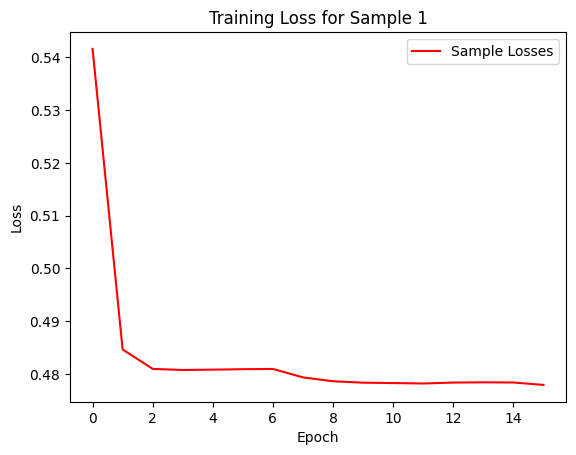

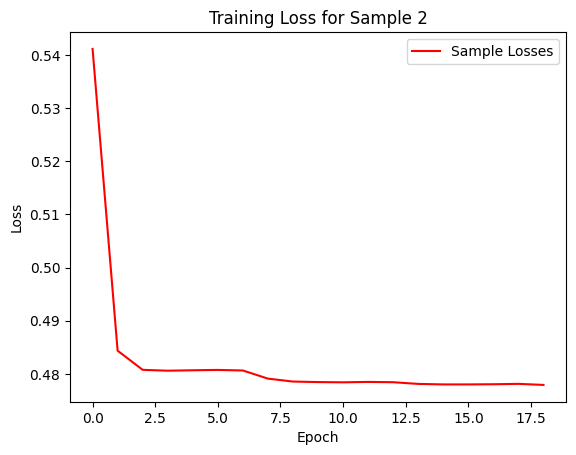

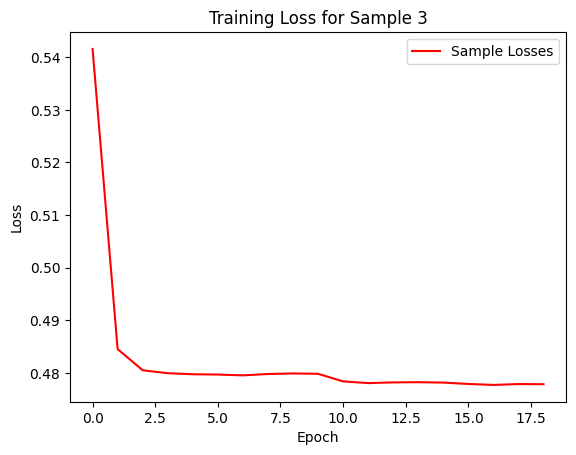

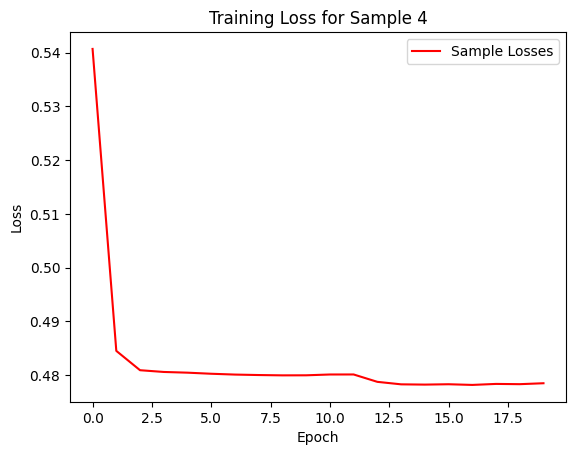

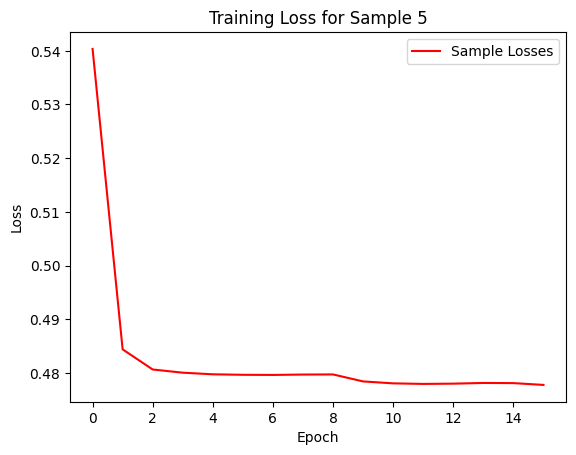

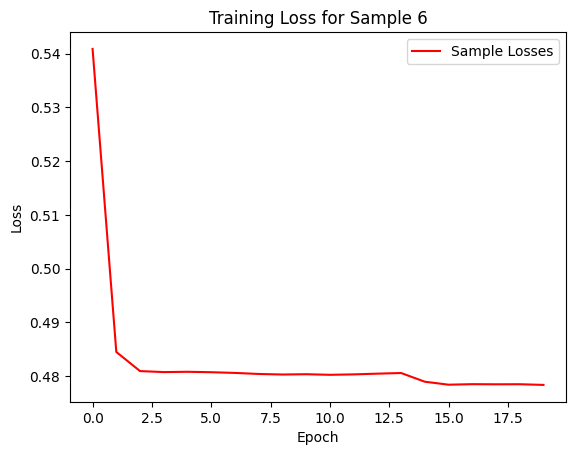

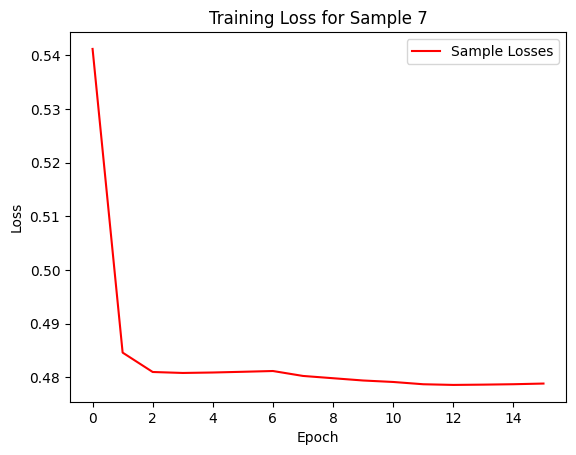

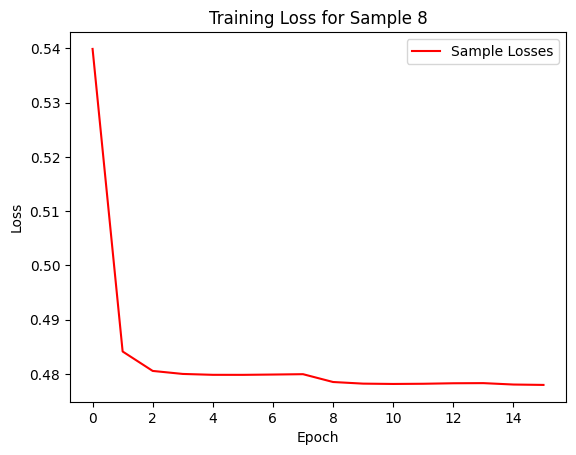

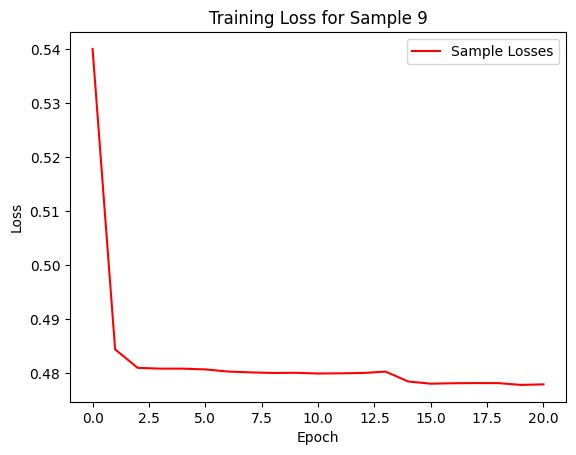

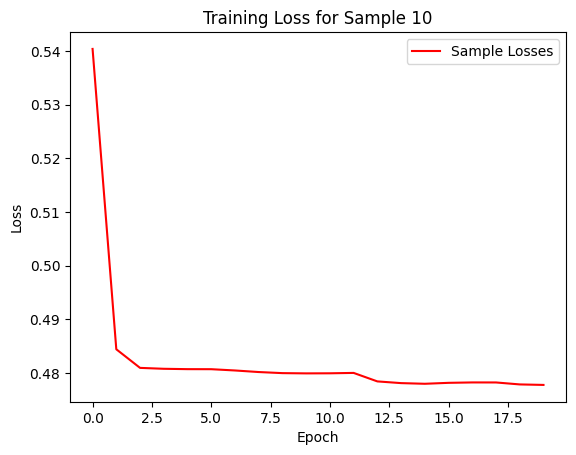

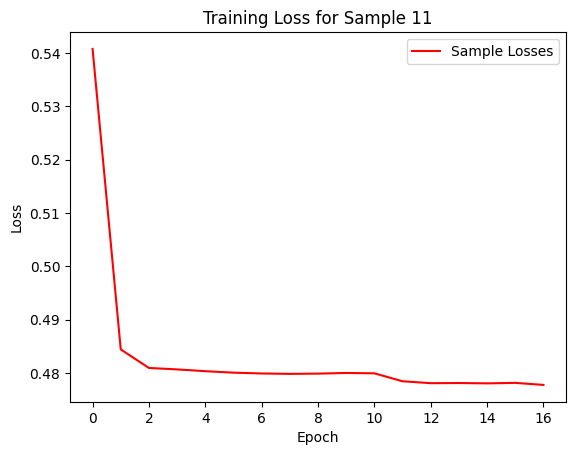

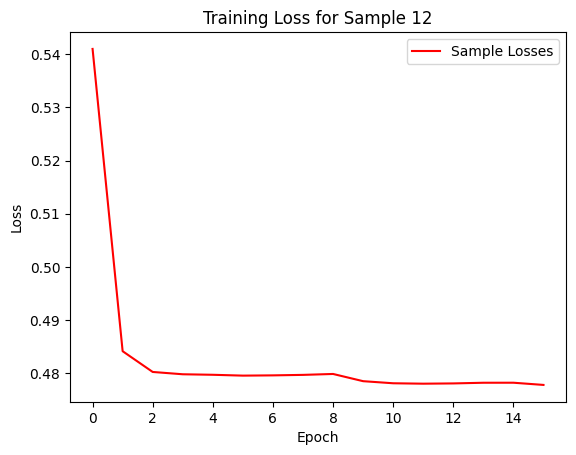

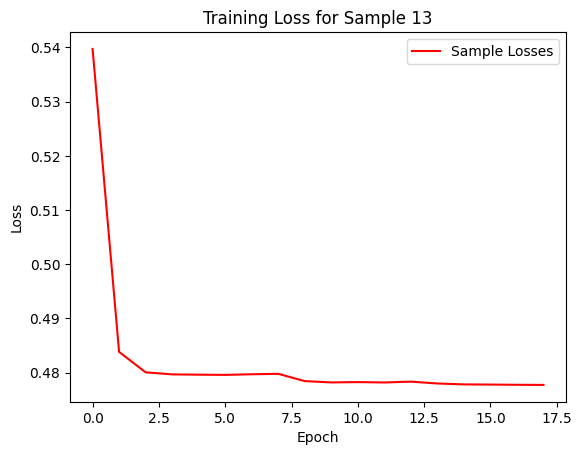

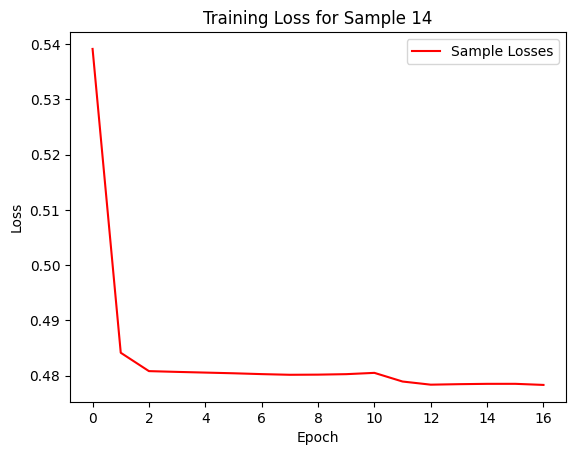

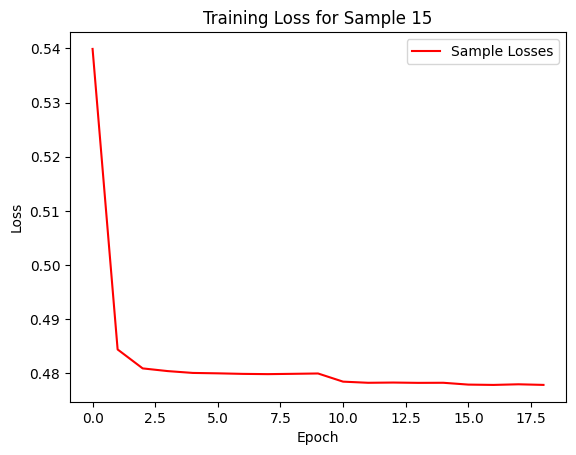

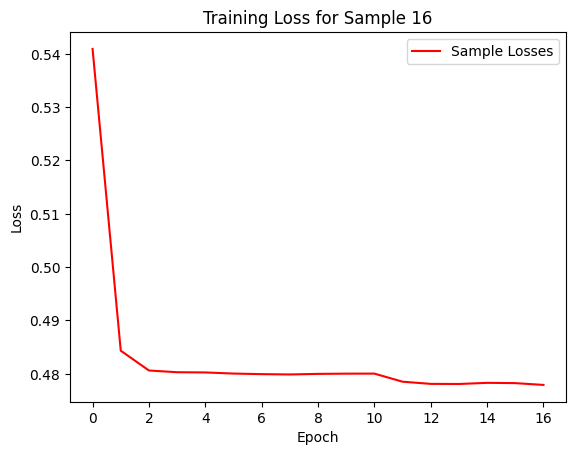

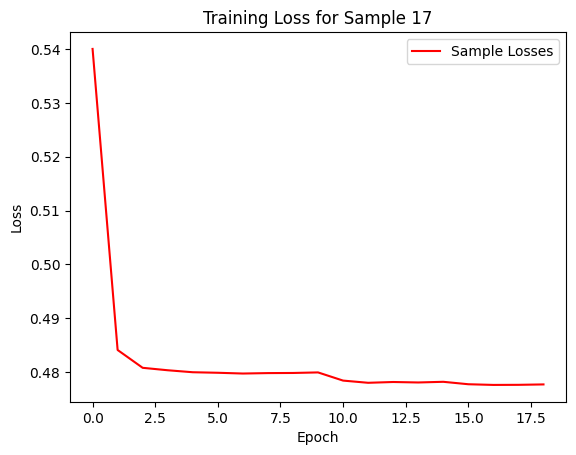

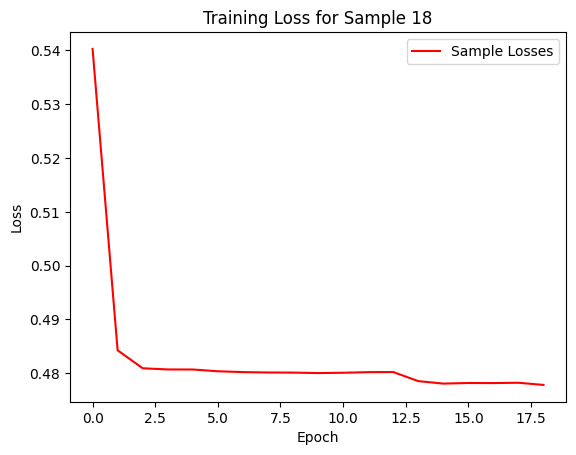

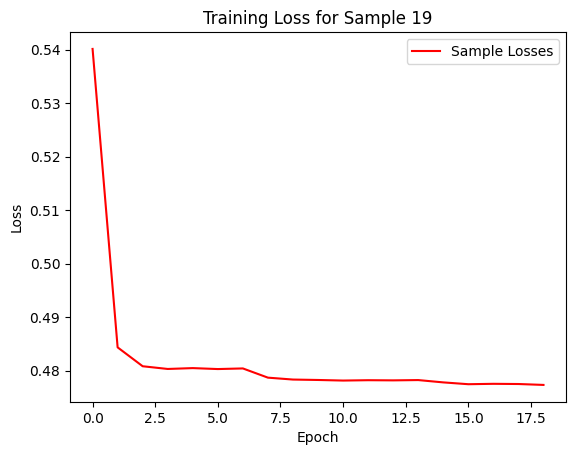

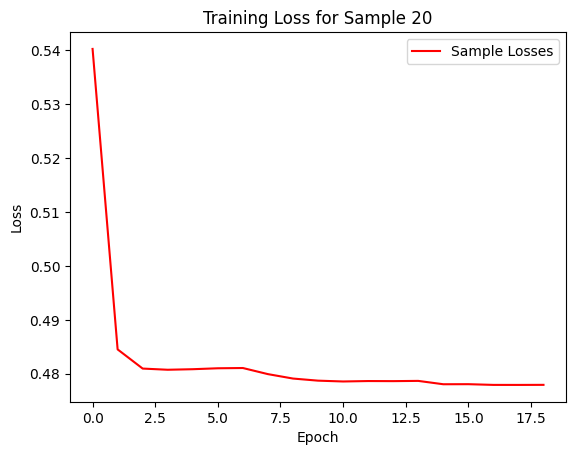

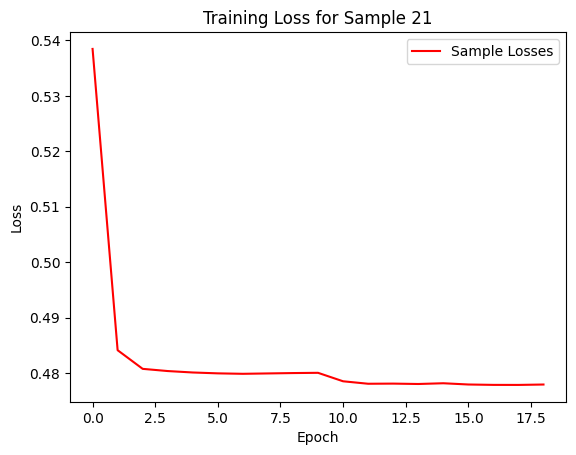

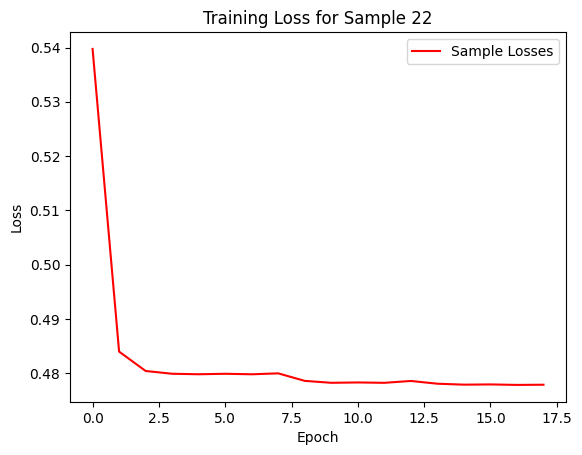

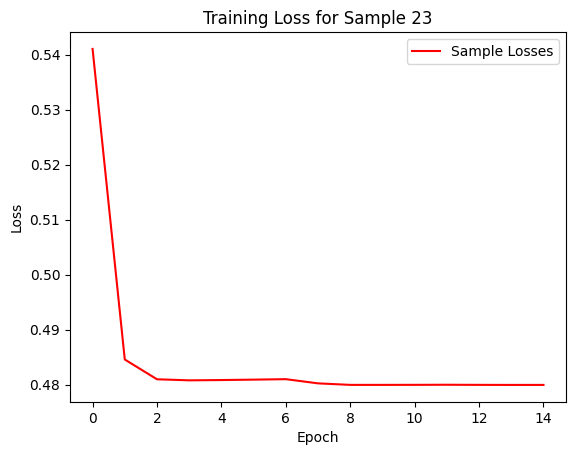

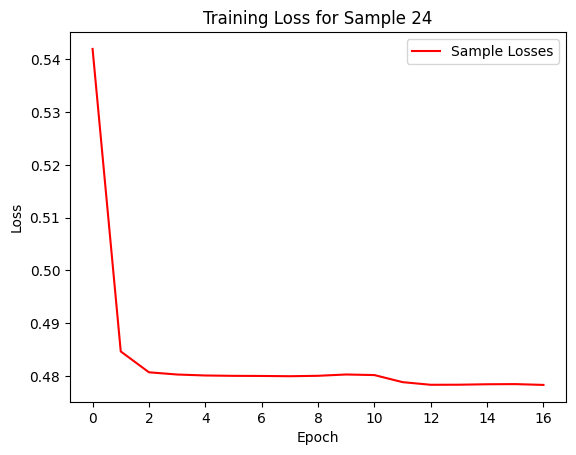

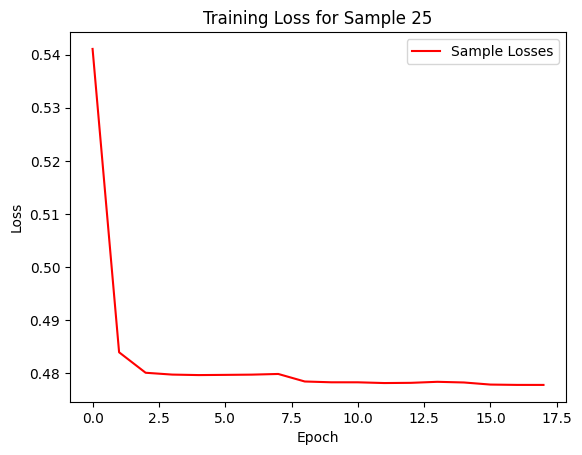

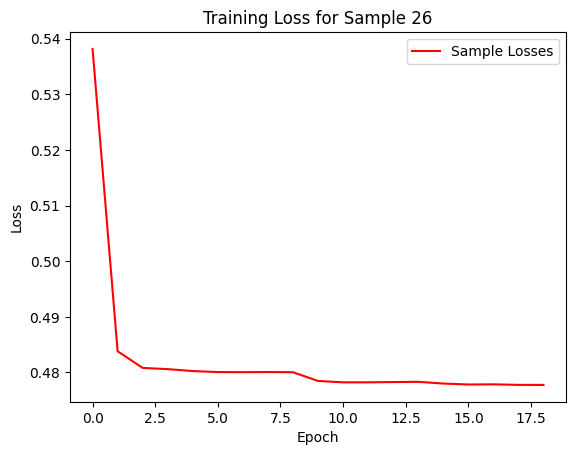

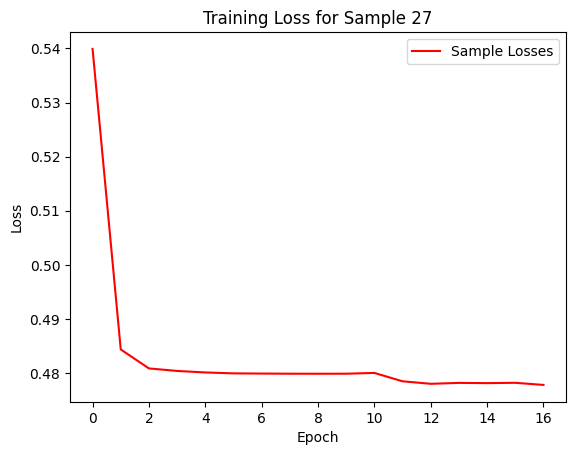

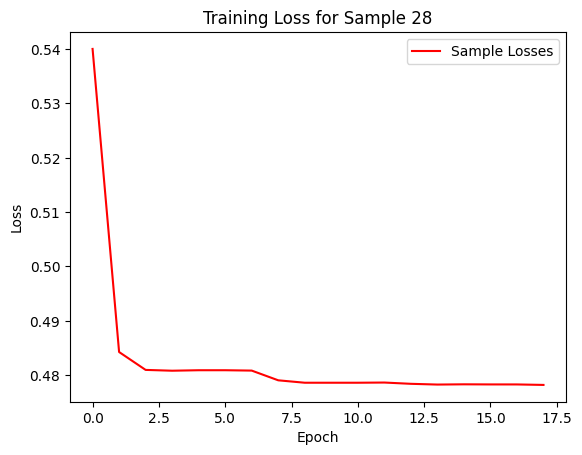

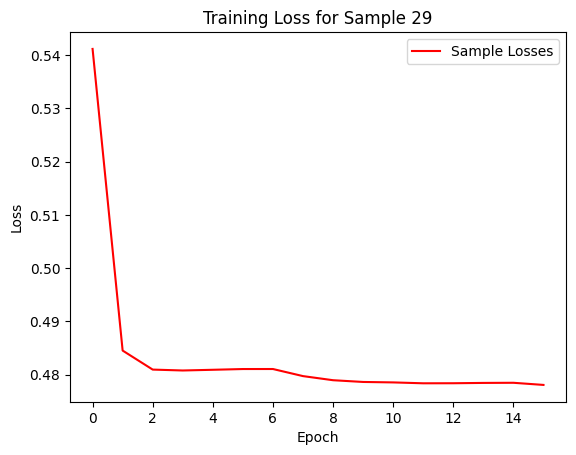

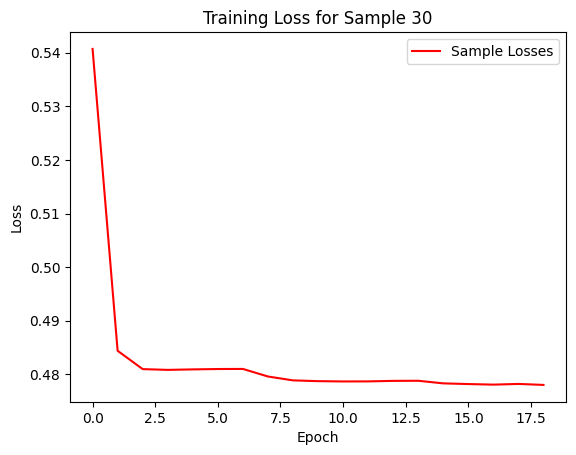

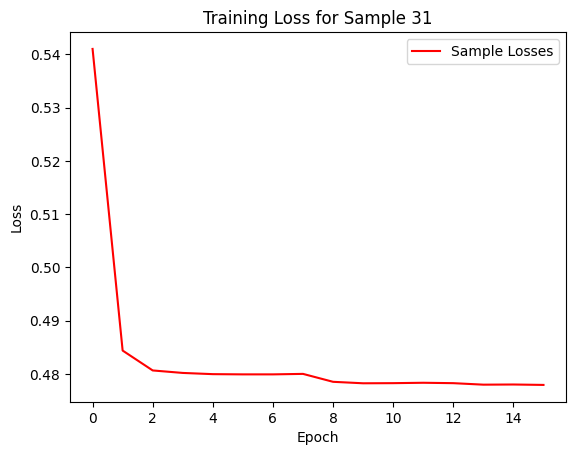

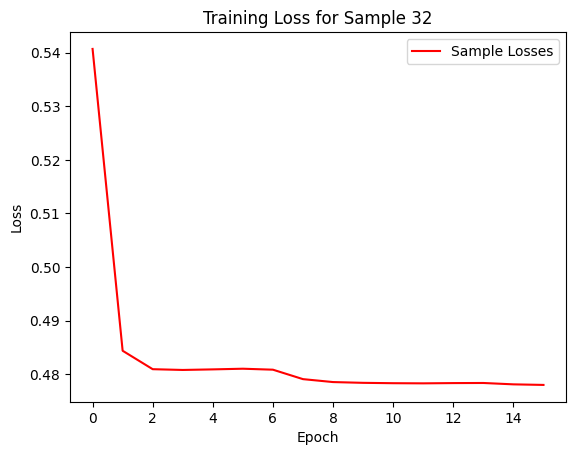

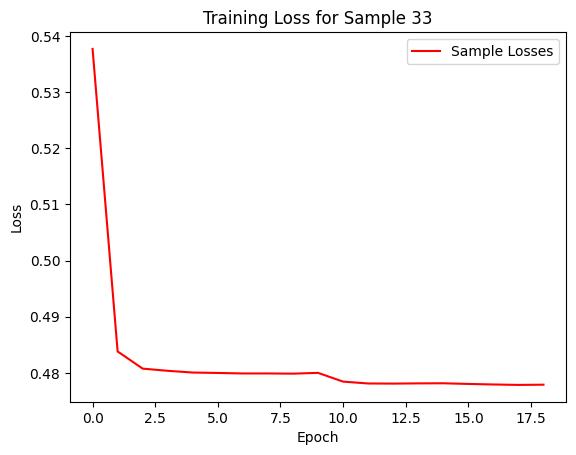

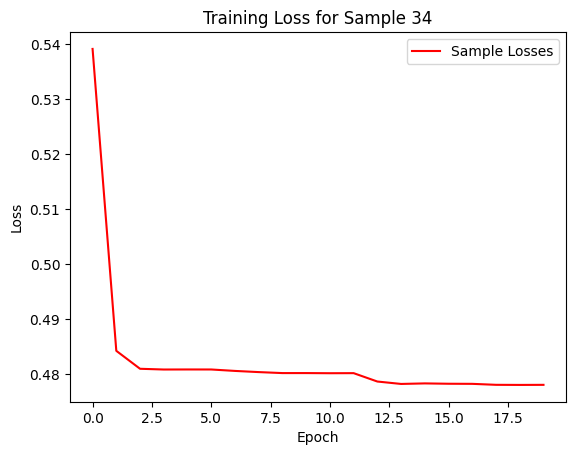

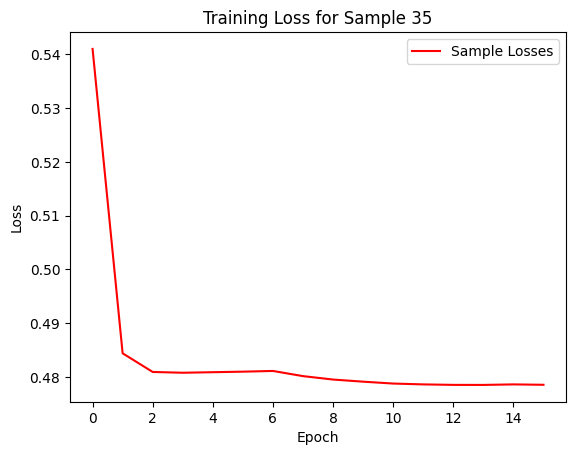

In [ ]:
for i, (sample_losses) in enumerate(all_sample_losses):
    plt.figure()  # Create a new figure for each sample

    # Plot sample losses
    plt.plot(sample_losses, label='Sample Losses', linestyle='solid', color='red')

    # Add labels, title, and legend
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training Loss for Sample {i+1}')
    plt.legend()

    # Show the plot
    plt.show()

In [ ]:
print(np.mean(all_hitrates), " +- ", np.std(all_hitrates))
print(np.mean(all_mrr), " +- ", np.std(all_mrr))

0.06043465570784128  +-  0.015526755663553918
0.08368458479110684  +-  0.014348683166812183


In [ ]:
hitrates_50 = [hit[0] for hit in all_hitrates]
hitrates_100 = [hit[1] for hit in all_hitrates]

In [ ]:
mean_hitrate_50 = np.mean(hitrates_50)
std_hitrate_50 = np.std(hitrates_50)
mean_hitrate_100 = np.mean(hitrates_100)
std_hitrate_100 = np.std(hitrates_100)
mean_mrr = np.mean(all_mrr)
std_mrr = np.std(all_mrr)

print(f"Mean Hitrate @ 50: {mean_hitrate_50} +- {std_hitrate_50}")
print(f"Mean Hitrate @ 100: {mean_hitrate_100} +- {std_hitrate_100}")
print(f"Mean MRR: {mean_mrr} += {std_mrr}")

Mean Hitrate @ 50: 0.04700336493362635 +- 0.006630733461029123
Mean Hitrate @ 100: 0.07386594648205622 +- 0.008797415127023025
Mean MRR: 0.08368458479110684 += 0.014348683166812183


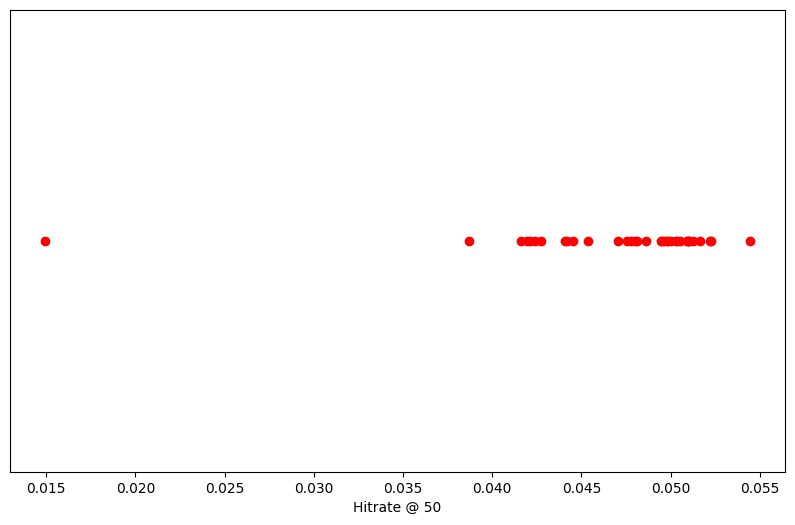

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(hitrates_50, np.zeros_like(hitrates_50), color='red', marker='o')
plt.xlabel('Hitrate @ 50')
plt.yticks([])
plt.show()

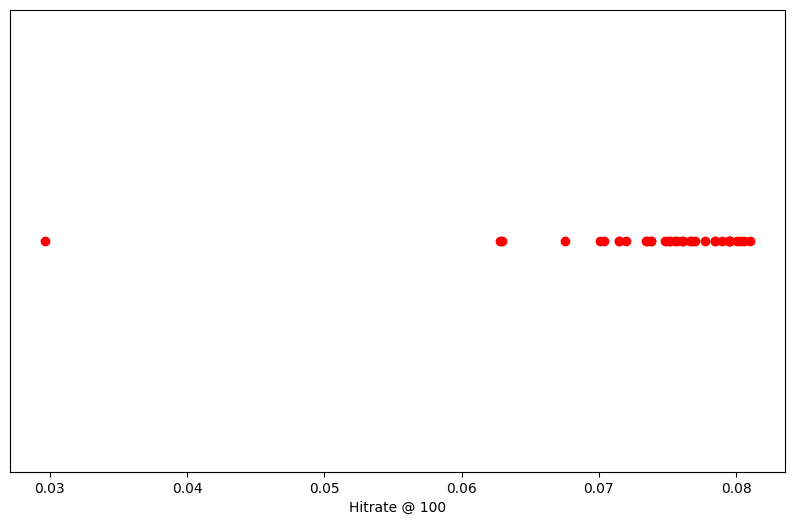

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(hitrates_100, np.zeros_like(hitrates_100), color='red', marker='o')
plt.xlabel('Hitrate @ 100')
plt.yticks([])
plt.show()

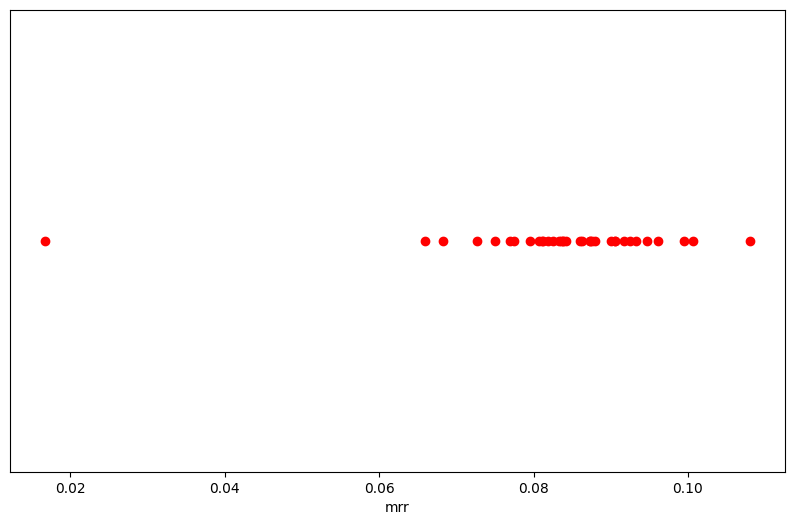

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(all_mrr, np.zeros_like(all_mrr), color='red', marker='o')
plt.xlabel('mrr')
plt.yticks([])
plt.show()

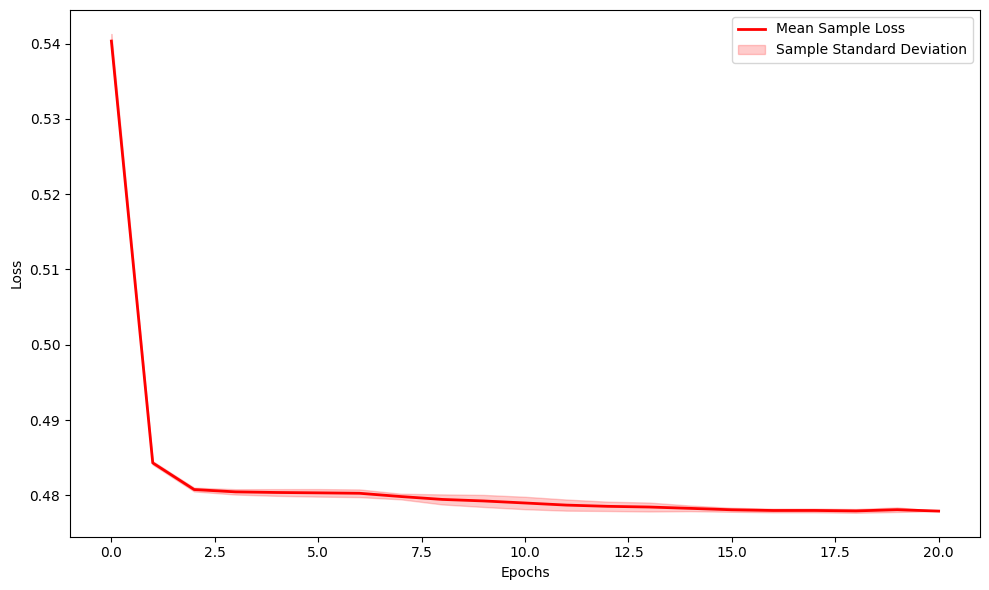

In [ ]:
max_length = max(len(curve) for curve in all_sample_losses)

padded_sample_losses = np.array([
    np.pad(curve, (0, max_length - len(curve)), constant_values=np.nan)
    for curve in all_sample_losses
])

#mean_batch_loss = np.nanmean(padded_batch_losses, axis=0)
#std_batch_loss = np.nanstd(padded_batch_losses, axis=0)
mean_sample_loss = np.nanmean(padded_sample_losses, axis=0)
std_sample_loss = np.nanstd(padded_sample_losses, axis=0)

plt.figure(figsize=(10, 6))
#plt.plot(mean_batch_loss, label='Mean Batch Loss', color='blue', linewidth=2)
plt.plot(mean_sample_loss, label='Mean Sample Loss', color='red', linewidth=2)

plt.fill_between(
    np.arange(max_length),
    mean_sample_loss - std_sample_loss,
    mean_sample_loss + std_sample_loss,
    color='red',
    alpha=0.2,
    label='Sample Standard Deviation'
)

plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.title('Loss Curves with Mean and Standard Deviation')
plt.legend()
plt.tight_layout()

plt.savefig('mean-loss-call.pdf', format='pdf')

plt.show()